<a href="https://colab.research.google.com/github/victor-hro/MachineLearning_UFSC/blob/master/Exercicio8_Victor(c%C3%B3pia).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514 / EEL7513 / EEL410250 - Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bU}{\mathbf{U}}$
$\newcommand{\bu}{\mathbf{u}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\calS}{\mathcal{S}}$


# Exercício 8: Redes Convolucionais

Neste exercício você irá utilizar redes convolucionais para reconhecimento de imagens. Além de treinar uma rede a partir do zero, você irá investigar a técnica de ajuste fino (*fine tuning*) a partir de uma rede pré-treinada (*transfer learning*).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import sys
import tensorflow as tf
print('Python', sys.version.split(' ')[0])
print('TensorFlow', tf.__version__)
#print('GPU:', tf.config.list_physical_devices('GPU'))
devs = tf.python.client.device_lib.list_local_devices()
devs = {devs[i].device_type: devs[i].physical_device_desc for i in range(len(devs))}
if 'GPU' in devs:
  print('GPU:', devs['GPU'].split('name: ')[1].split(', ')[0])
else:
  print('GPU: None')

Python 3.6.9
TensorFlow 2.3.0
GPU: Tesla K80


In [2]:
def plots(history):
  plt.figure(figsize=(14,4))
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.history.keys():
    plt.plot(history.history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs');
  plt.legend();
  plt.grid();
  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'], '.-', label='Train accuracy')
  plt.xlabel('Epochs');
  if 'val_accuracy' in history.history.keys():
    plt.plot(history.history['val_accuracy'], '.-', label='Val accuracy')
  plt.legend();
  plt.grid();

# 1. Treinando a partir do zero

## MNIST

1. Assim como no exercício anterior, carregue o conjunto MNIST e separe as últimas 5000 imagens como conjunto de validação. No entanto, desta vez não realize qualquer pré-processamento nas imagens (como escalonamento); isto será feito [internamente no modelo](https://keras.io/guides/preprocessing_layers/#preprocessing-data-before-the-model-or-inside-the-model) depois.

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(5000/60000), random_state=0)

In [5]:
#x_train = x_train.astype('uint8')
#x_val = x_val.astype('uint8')

print(x_train.dtype)
print(f'Train shapes: {x_train.shape, y_train.shape}')
print(f'  Val shapes: {x_val.shape, y_val.shape}')
print(f' Test shapes: {x_test.shape, y_test.shape}')

float64
Train shapes: ((55000, 28, 28), (55000,))
  Val shapes: ((5000, 28, 28), (5000,))
 Test shapes: ((10000, 28, 28), (10000,))


2. Usando o Keras, construa uma rede neural com pelo menos uma camada convolucional (`tf.keras.layers.Conv2D`) e confirme que não há nenhum erro de definição. Organize seu código em uma função de criação do modelo, conforme o exemplo abaixo (dê o nome que preferir). Utilize camadas de escalonamento e *reshape* conforme necessário.

#### Dicas
- Funções úteis: `tf.keras.layers.experimental.preprocessing.Rescaling`, `tf.keras.layers.Reshape`
- Camadas convolucionais 2D exigem que a entrada seja um tensor 3D, sendo o último eixo correspondente ao número de canais (no caso, apenas 1, para uma imagem em tons de cinza).

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras        import layers

In [7]:
def make_model():
  tf.random.set_seed(1)
  model = Sequential(
      [
        layers.Input(shape = (28,28)),
        layers.Reshape(input_shape = (28*28,), target_shape = (28,28,1)),
        layers.experimental.preprocessing.Rescaling(1./255),

        layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),

        layers.Flatten(),
        Dense(64, activation = 'relu'),
        Dense(10, activation = 'softmax')
      ]
  )
  return model

make_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [8]:
%%time
model = make_model()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val,y_val), verbose = True)

Epoch 1/10
430/430 [==============================] - 3s 7ms/step - loss: 0.5286 - accuracy: 0.8529 - val_loss: 0.9958 - val_accuracy: 0.7544
Epoch 2/10
430/430 [==============================] - 3s 6ms/step - loss: 0.2363 - accuracy: 0.9295 - val_loss: 0.2170 - val_accuracy: 0.9368
Epoch 3/10
430/430 [==============================] - 3s 6ms/step - loss: 0.1756 - accuracy: 0.9479 - val_loss: 0.1563 - val_accuracy: 0.9536
Epoch 4/10
430/430 [==============================] - 3s 6ms/step - loss: 0.1383 - accuracy: 0.9596 - val_loss: 0.1608 - val_accuracy: 0.9514
Epoch 5/10
430/430 [==============================] - 3s 6ms/step - loss: 0.1125 - accuracy: 0.9672 - val_loss: 0.1108 - val_accuracy: 0.9660
Epoch 6/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0949 - accuracy: 0.9721 - val_loss: 0.0864 - val_accuracy: 0.9736
Epoch 7/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0807 - accuracy: 0.9760 - val_loss: 0.0846 - val_accuracy: 0.9740
Epoch 

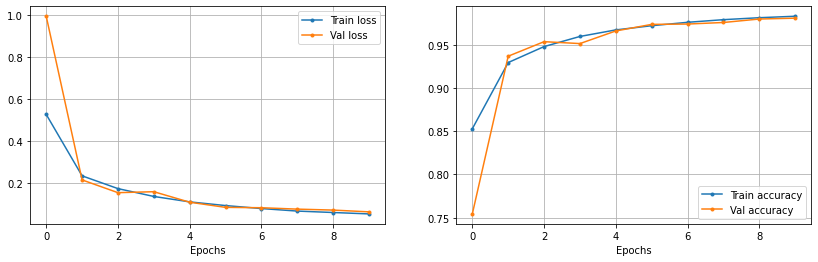

In [11]:
plots(history)

3. Desenvolva (i.e., aprimore a arquitetura) e treine sua rede (a partir do zero), tentando conseguir uma acurácia de validação de pelo menos 99.2%. (Lembre que usando apenas camadas densas é difícil conseguir uma acurácia muito superior a 98%.) Em seguida, calcule a acurácia no conjunto de teste.

1. (OPCIONAL) Por que o uso de Dropout faz com que o desempenho de treinamento comece bastante inferior ao de validação?

#### Dicas
- Parta da arquitetura deste [tutorial](https://keras.io/examples/vision/mnist_convnet) (com os devidos ajustes feitos no item anterior) e adicione uma camada densa com um número suficiente de unidades. Lembre-se de (ao contrário do tutorial) trazer para dentro do modelo qualquer pré-processamento necessário.
- Visualize os gráficos do treinamento usando a função `plots` fornecida (ou a ferramenta TensorBoard).
- Ao usar camadas convolucionais com GPU, a execução paralelizada torna impossível garantir a reproducibilidade, portanto, não perca tempo com isso.

In [32]:
def make_model():
  tf.random.set_seed(1)
  model = Sequential(
      [
        layers.Input(shape = (28,28)),
        layers.Reshape(input_shape = (28*28,), target_shape = (28,28,1)),
        layers.experimental.preprocessing.Rescaling(1./255),

        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),
       
        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),

        layers.Flatten(),
        Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        Dense(64, activation = 'relu'),
        layers.Dropout(0.2),
        Dense(10, activation = 'softmax')
      ]
  )
  return model

make_model().summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 26, 26, 64)        192       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
batch_normalization_9 (Batch (None, 11, 11, 64)       

In [22]:
%%time
model = make_model()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_val,y_val), verbose = True)

Epoch 1/30
430/430 [==============================] - 6s 13ms/step - loss: 0.2469 - accuracy: 0.9227 - val_loss: 2.2193 - val_accuracy: 0.1138
Epoch 2/30
430/430 [==============================] - 5s 12ms/step - loss: 0.0733 - accuracy: 0.9784 - val_loss: 0.0607 - val_accuracy: 0.9818
Epoch 3/30
430/430 [==============================] - 5s 12ms/step - loss: 0.0545 - accuracy: 0.9842 - val_loss: 0.0527 - val_accuracy: 0.9852
Epoch 4/30
430/430 [==============================] - 5s 12ms/step - loss: 0.0426 - accuracy: 0.9874 - val_loss: 0.0753 - val_accuracy: 0.9772
Epoch 5/30
430/430 [==============================] - 5s 12ms/step - loss: 0.0368 - accuracy: 0.9891 - val_loss: 0.0840 - val_accuracy: 0.9752
Epoch 6/30
430/430 [==============================] - 5s 12ms/step - loss: 0.0310 - accuracy: 0.9902 - val_loss: 0.0314 - val_accuracy: 0.9896
Epoch 7/30
430/430 [==============================] - 5s 12ms/step - loss: 0.0263 - accuracy: 0.9921 - val_loss: 0.0318 - val_accuracy: 0.9912

In [23]:
# tentando conseguir uma acurácia de validação de pelo menos 99.2%.
train_evaluate = model.evaluate(x_train,y_train)
val_evaluate = model.evaluate(x_val,y_val)

157/157 [==============================] - 1s 4ms/step - loss: 0.0472 - accuracy: 0.9912


In [24]:
print(f'Train evaluate: {round(train_evaluate[1],3)*100}%')
print(f'  Val evaluate: {round(val_evaluate[1],3)*100}%')

Train evaluate: 99.9%
  Val evaluate: 99.1%


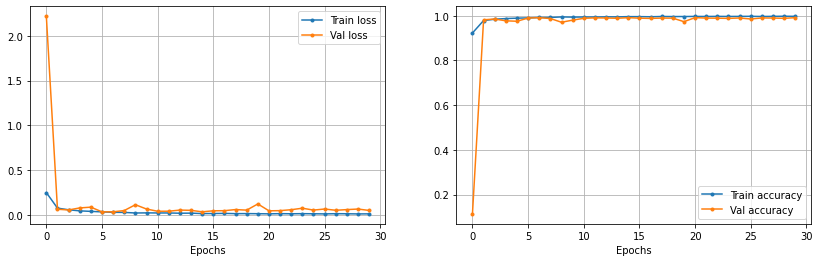

In [25]:
plots(history) #batch_size=128, epochs=20

In [27]:
# armazenando o modelo num arquivo .json
model_json = model.to_json()
with open('model_mnist.json', 'w') as json_file:
  json_file.write(model_json)

# armazenando os pesos num arquivo .h5
model.save_weights('model_mnist.h5')

In [28]:
from keras.models import model_from_json

file = open('model_mnist.json', 'r')
model = file.read()
file.close()

model = model_from_json(model)
model.load_weights('model_mnist.h5')

## (OPCIONAL) Fashion-MNIST

5. (OPCIONAL) Repita para o conjunto [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist), o qual também está [disponível no Keras](https://keras.io/api/datasets/fashion_mnist). Nesse caso, é suficiente aproveitar a mesma arquitetura do modelo e apenas (se necessário) alterar a taxa de aprendizado e o número de épocas. Sem muito esforço é possível conseguir uma acurácia de validação de 92% (em comparação com 87% para uma rede densa). Se desejar, visualize algumas imagens do conjunto de treinamento e algumas predições erradas no conjunto de teste.

## CIFAR-10

Agora, vamos utilizar um conjunto um pouco mais complexo, o [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10), também [disponível no Keras](https://keras.io/datasets/).


In [29]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train.dtype:', x_train.dtype)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 11s 0us/step
x_train.dtype: uint8
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


Observe que o `shape` do array `y` precisa ser corrigido:
- Para usar a perda `sparse_categorical_crossentropy`, `y` precisa ser um tensor 1D com valores em `[0, 1, ..., n_classes-1]`
- Para usar a perda `categorical_crossentropy`, `y` precisa ser um tensor 2D com *shape* `(n_samples, n_classes)` e codificação *one-hot*


In [30]:
# Make sure y is a 1D tensor, so we can use sparse_categorical_crossentropy loss
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=5000, shuffle=False)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(45000, 32, 32, 3) (45000,)
(5000, 32, 32, 3) (5000,)
(10000, 32, 32, 3) (10000,)


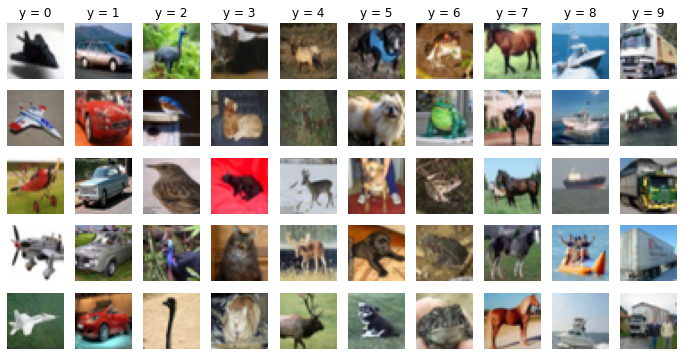

In [31]:
plt.figure(figsize=(12,6))
for i in range(5):
  for c in range(10):
    plt.subplot(5, 10, 10*i+c+1)
    img = x_train[y_train == c][i]
    plt.imshow(img)
    if i == 0:
      plt.title('y = {}'.format(c))
    plt.axis('off')

6. Inicialmente, apenas converta a mesma arquitetura utilizada no MNIST para o formato das imagens do CIFAR-10 e treine o modelo. Note que agora não é mais necessário usar uma camada `Reshape`. Certifique-se de escolher um batch size e taxa de aprendizado apropriadas. Observe que é difícil obter uma acurácia de validação superior a 73%.

7. Por que você acha que isso acontece? Explique.

In [35]:
def make_model():
  tf.random.set_seed(1)
  model = Sequential(
      [
        layers.Input(shape = (32,32,3)),
        layers.experimental.preprocessing.Rescaling(1./255),

        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),
       
        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),

        layers.Flatten(),
        Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        Dense(64, activation = 'relu'),
        layers.Dropout(0.2),
        Dense(10, activation = 'softmax')
      ]
  )
  return model

make_model().summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization_14 (Batc (None, 30, 30, 64)        192       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
batch_normalization_15 (Batc (None, 13, 13, 64)        192       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 64)         

In [36]:
model = make_model()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=150, validation_data=(x_val,y_val))

Epoch 1/150
352/352 [==============================] - 5s 15ms/step - loss: 1.6045 - accuracy: 0.4294 - val_loss: 3.0841 - val_accuracy: 0.2288
Epoch 2/150
352/352 [==============================] - 5s 14ms/step - loss: 1.2074 - accuracy: 0.5796 - val_loss: 1.0746 - val_accuracy: 0.6150
Epoch 3/150
352/352 [==============================] - 5s 14ms/step - loss: 1.0244 - accuracy: 0.6420 - val_loss: 1.1100 - val_accuracy: 0.6198
Epoch 4/150
352/352 [==============================] - 5s 14ms/step - loss: 0.9004 - accuracy: 0.6860 - val_loss: 0.9305 - val_accuracy: 0.6848
Epoch 5/150
352/352 [==============================] - 5s 14ms/step - loss: 0.7941 - accuracy: 0.7239 - val_loss: 0.9925 - val_accuracy: 0.6558
Epoch 6/150
352/352 [==============================] - 5s 14ms/step - loss: 0.7201 - accuracy: 0.7505 - val_loss: 0.8406 - val_accuracy: 0.7154
Epoch 7/150
352/352 [==============================] - 5s 14ms/step - loss: 0.6472 - accuracy: 0.7736 - val_loss: 0.8201 - val_accuracy:

In [39]:
train_evaluate = model.evaluate(x_train,y_train)
val_evaluate  = model.evaluate(x_val,y_val)
print(f'Train evaluate: {round(train_evaluate[1],3)*100}%')
print(f'  Val evaluate: {round(val_evaluate[1],3)*100}%')

157/157 [==============================] - 1s 4ms/step - loss: 1.8008 - accuracy: 0.7354


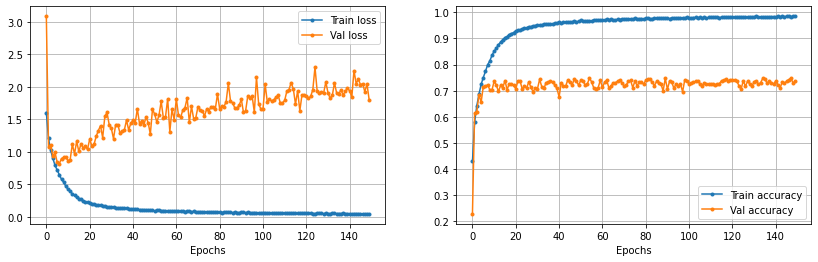

In [41]:
plots(history)

In [42]:
# armazenando o modelo num arquivo .json
model_json = model.to_json()
with open('CIFAR.json', 'w') as json_file:
  json_file.write(model_json)

# armazenando os pesos num arquivo .h5
model.save_weights('CIFAR.h5')

In [ ]:
'''
from keras.models import model_from_json

file = open('CIFAR.json', 'r')
model = file.read()
file.close()

model = model_from_json(model)
model.load_weights('CIFAR.h5')
'''

"\nfrom keras.models import model_from_json\n\nfile = open('CIFAR.json', 'r')\nmodel = file.read()\nfile.close()\n\nmodel = model_from_json(model)\nmodel.load_weights('CIFAR.h5')\n"

### Data augmentation
Para melhorar o desempenho, utilizaremos a técnica de aumento de dados (*data augmentation*). Há duas formas principais de utilizar esta técnica no Keras:
- Usando a função [`tf.keras.preprocessing.image.ImageDataGenerator`](https://keras.io/api/preprocessing/image/#imagedatagenerator-class), a qual opcionalmente permite aplicar transformações aleatórias. Esta é a abordagem mais tradicional.
- Usando camadas de *data augmentation* como parte do modelo, as quais aplicam transformações aleatórias *somente* durante o treinamento (ficando inativas fora do treinamento). Esta é uma abordagem mais recente e ainda experimental. A principal vantagem é tornar as operações mais rápidas pelo uso da GPU, conforme explicado [neste tutorial](https://keras.io/guides/preprocessing_layers/#preprocessing-data-before-the-model-or-inside-the-model) e também [neste](https://keras.io/examples/vision/image_classification_from_scratch/#two-options-to-preprocess-the-data).

Para acelerar o treinamento usaremos aqui a segunda abordagem. Um exemplo é mostrado abaixo; você pode adicionar outras transformações se desejar.



In [43]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomTranslation
data_augmentation = Sequential(
    [
     RandomTranslation(height_factor=0.1, width_factor=0.1),
     RandomFlip(mode='horizontal'),
    ],
    name='data_augmentation',
)

In [50]:
def make_model():
  model = Sequential(
      [
        layers.Input(shape=(32, 32, 3)),
        data_augmentation,
       
        layers.Conv2D(filters = 32, kernel_size = (3,3), padding='same', activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),
       
        layers.Conv2D(filters = 64, kernel_size = (3,3), padding='same', activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),

        layers.Conv2D(filters = 64, kernel_size = (3,3), padding='same', activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),

        layers.Flatten(),
        Dense(128, activation = 'relu'),
        layers.Dropout(0.3),
        Dense(64, activation = 'relu'),
        layers.Dropout(0.3),
        Dense(10, activation='softmax'),
      ]
  )
  return model
make_model().summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 32)        96        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 16, 64)        192       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 8, 8, 64)        

**Obs:** Aparentemente há um bug ainda não resolvido nas camadas `RandomTranslation` e `RandomRotation`, conforme descrito [aqui](https://stackoverflow.com/questions/62339559/black-pixels-outside-the-border-when-using-keras-layers-experimental-preprocessi) e visualizado por exemplo [aqui](https://keras.io/examples/vision/image_classification_from_scratch/#using-image-data-augmentation), [aqui](https://keras.io/guides/transfer_learning/#using-random-data-augmentation) e nas imagens abaixo. (Não deveria haver bordas pretas nas imagens transformadas.) Felizmente esse defeito não afeta o desempenho de forma significativa.

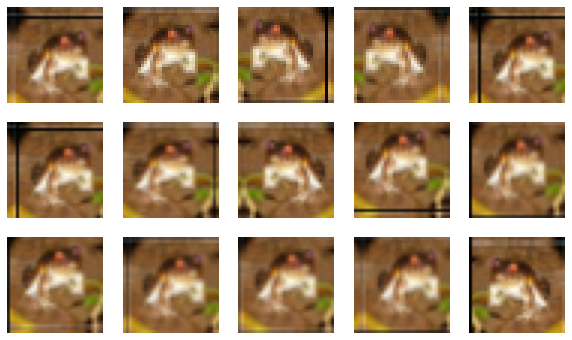

In [45]:
plt.figure(figsize=(10, 6))
i = 0
for j in range(15):
  img = data_augmentation(x_train[[i]])[0].numpy()
  plt.subplot(3, 5, j+1)
  plt.imshow(img.astype('uint8'))
  plt.axis('off')

8. Treine o modelo até obter pelo menos 80% de acurácia de validação. Note que será preciso um número elevado de épocas (100 ou mais), o que deve levar vários minutos.

#### Dicas
- Certifique-se de usar uma taxa de aprendizado apropriada ao longo de todo o treinamento. Por exemplo:
 - Treine por N épocas com taxa constante, observe os resultados, depois continue o treinamento por mais N épocas, etc. Se em algum ponto o desempenho não estiver melhorando, reduza manualmente a taxa de aprendizado;
 - Utilize uma *callback* de decaimento, como [`ReduceLROnPlateau`](https://keras.io/api/callbacks/reduce_lr_on_plateau/) ou a genérica [`LearningRateScheduler`](https://keras.io/api/callbacks/learning_rate_scheduler/); ou
 - Utilize um valor pequeno constante e tenha bastante paciência.

-  Fique à vontade para aprimorar o modelo se desejar. Para facilitar, você pode se basear em quaisquer outras referências ou tutoriais disponíveis, como por exemplo: [Tutorial 1](https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras) ou [Tutorial 2](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification). Note que alguns tutoriais estão desatualizados; por exemplo, a função `fit_generator` tornou-se obsoleta, tendo sido incorporada à função `fit`. No entanto, esteja ciente de que não é necessário um modelo muito complexo para obter a acurácia desejada.

In [52]:
%%time
model = make_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# monitor: quantity to be monitored.
# factor: factor by which the learning rate will be reduced. new_lr = lr * factor.
# patience: number of epochs with no improvement after which learning rate will be reduced.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001)

history = model.fit(x_train, y_train, batch_size=256, epochs=150, validation_data=(x_val,y_val), callbacks=[reduce_lr])

Epoch 1/150
176/176 [==============================] - 4s 26ms/step - loss: 1.9082 - accuracy: 0.3080 - val_loss: 1.7162 - val_accuracy: 0.3818
Epoch 2/150
176/176 [==============================] - 4s 24ms/step - loss: 1.5249 - accuracy: 0.4523 - val_loss: 1.4894 - val_accuracy: 0.4820
Epoch 3/150
176/176 [==============================] - 4s 24ms/step - loss: 1.3547 - accuracy: 0.5178 - val_loss: 1.1635 - val_accuracy: 0.5868
Epoch 4/150
176/176 [==============================] - 4s 24ms/step - loss: 1.2389 - accuracy: 0.5649 - val_loss: 1.2517 - val_accuracy: 0.5824
Epoch 5/150
176/176 [==============================] - 4s 23ms/step - loss: 1.1522 - accuracy: 0.5984 - val_loss: 1.2171 - val_accuracy: 0.5904
Epoch 6/150
176/176 [==============================] - 4s 23ms/step - loss: 1.0854 - accuracy: 0.6225 - val_loss: 1.3915 - val_accuracy: 0.5638
Epoch 7/150
176/176 [==============================] - 4s 23ms/step - loss: 1.0293 - accuracy: 0.6433 - val_loss: 1.3849 - val_accuracy:

157/157 [==============================] - 1s 4ms/step - loss: 0.5199 - accuracy: 0.8372
Train evaluate: 90.0%
  Val evaluate: 83.7%


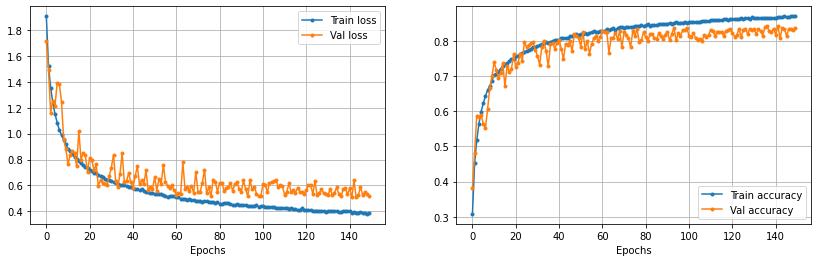

In [53]:
train_evaluate = model.evaluate(x_train,y_train)
val_evaluate  = model.evaluate(x_val,y_val)
print(f'Train evaluate: {round(train_evaluate[1],3)*100}%')
print(f'  Val evaluate: {round(val_evaluate[1],3)*100}%')
plots(history)

In [58]:
# armazenando o modelo num arquivo .json
model_json = model.to_json()
with open('CIFAR_callbacks.json', 'w') as json_file:
  json_file.write(model_json)

# armazenando os pesos num arquivo .h5
model.save_weights('CIFAR_callbacks.h5')

# 2. Usando uma rede pré-treinada (*transfer learning & fine-tuning*)

1. Partindo de alguma [rede pré-treinada](https://keras.io/applications/)  fornecida pelo Keras, treine uma rede convolucional para [classificação entre gatos e cachorros](https://www.kaggle.com/c/dogs-vs-cats). Para isto, siga este [tutorial](https://keras.io/guides/transfer_learning) (provavelmente o mais atualizado no momento e escrito pelo próprio criador do Keras). Antes de seguir o tutorial, provavelmente será útil conhecer os conceitos básicos da [API funcional](https://keras.io/guides/functional_api/) do Keras.
1. (OPCIONAL) Experimente outros modelos pré-treinados e/ou outros conjuntos de dados. O [tutorial específico sobre EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) pode ser interessante.
1. (OPCIONAL) Se desejar, você pode aplicar um modelo pré-treinado para classificaro CIFAR-10. No entanto, para obter um desempenho satisfatório nesse caso, será necessário previamente alargar (*resize*) as imagens para um tamanho mais próximo do das imagens da ImageNet (`224 x 224`), para que os filtros treinados possam ser relevantes. Por outro lado, um alargamento excessivo pode introduzir distorções (*artifacts*) que podem prejudicar o desempenho.

#### Dicas
- Antes de aplicar um modelo pré-treinado, geralmente é necessário realizar algum pré-processamento exigido pelo modelo. Ao invés de realizar esse pré-processamento manualmente, como feito no tutorial, é suficiente e mais conveniente utilizar a função `preprocess_input`, disponível no módulo de cada modelo pré-treinado. Por exemplo:
```python
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
base_model = ResNet50V2(include_top=False, input_shape=(150, 150, 3), pooling='avg')
base_model.trainable = False
(...)
x = preprocess_input(x)
x = base_model(x, training=False)
(...)
```
- Para inspecionar as camadas do modelo pré-treinado, utilize `base_model.summary()`
- Antes de utilizar um modelo com a opção `include_top=False`, é útil inspecionar o modelo completo (com a opção `include_top=True`), uma vez que será necessário recriar (e retreinar) as camadas finais removidas.
- Outras referências interessantes (embora mais antigas): [Tutorial 3](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/) e [Tutorial 4](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)

# 3. (OPCIONAL) Visualizando os padrões aprendidos

1. (OPCIONAL) Para alguma rede convolucional à sua escolha, visualize o que cada camada da rede "aprendeu"; mais precisamente, mostre exemplos de imagens de entrada que maximizam a ativação dos filtros em cada camada. Para isso, siga este [tutorial](https://keras.io/examples/vision/visualizing_what_convnets_learn/).